In [2]:
import pyodbc
from meyerDB import cable_connection

import matplotlib.pyplot as plt
import numpy as np
from IPython.display import HTML, display
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import LeavePOut
from sklearn.metrics import mean_absolute_percentage_error as mape
from sklearn import linear_model
from sklearn.neighbors import KNeighborsRegressor
from sklearn.dummy import DummyRegressor
import sklearn.preprocessing as pp
from sklearn.utils import shuffle
from scipy.optimize import curve_fit
from copy import deepcopy

from keras import models
from keras.layers import Dense, Dropout


# init db connection
conn = pyodbc.connect(cable_connection)
cursor = conn.cursor()
print('Database connection ok')

def display_table(data):
    html = "<table>"
    for row in data:
        html += "<tr>"
        for field in row:
            try:
                value = str(round(100*field, 1)).replace('.', ',') + '%'
            except:
                value = field
            html += "<td><h4>%s</h4><td>"%(value)
        html += "</tr>"
    html += "</table>"
    display(HTML(html))

def logifunc(x,x0,k,l):
    #l = 2300
    return l / (1 + np.exp(-k*(x - x0)))

Database connection ok


0.13529491274771308 0.038100033973740885 0.24029779605907192


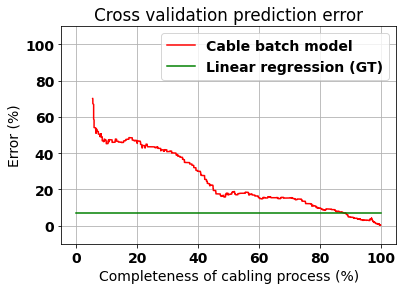

In [23]:
# Dynamic whole ship cable quantities
# Predictors:
# Current quantity, drawings
# Algorithms:
# average drawing cables

plt.rcParams['font.size'] = 14
plt.rcParams['font.weight'] = 'bold'
plt.rcParams["legend.loc"] = 'upper right'

def moving_average(a, n=3) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

# Get the data
cursor.execute("SELECT r.project_id, gross_tonnage, prototype, ship_squares, sum(amount) FROM routed as r"
    " LEFT JOIN projects as p ON p.project_id=r.project_id"
    " LEFT JOIN (SELECT project_id, sum(squares) as ship_squares FROM areas GROUP BY project_id) as a ON r.project_id=a.project_id"
    " GROUP BY r.project_id, gross_tonnage, prototype, ship_squares")
data = np.array(cursor.fetchall()).astype('float32')
ships = data[:, 0]
gt = data[:, 1]
y = data[:, -1]

# init lpo split
p = 2 #ships
lpo = LeavePOut(p)

# update temporary cable counts
cursor.execute("UPDATE progress SET cables=0")
cursor.execute(
    "UPDATE progress SET progress.cables=t1.cables FROM"
    " (SELECT project_id, pw, sum(amount) as cables FROM ship_readiness GROUP BY project_id, pw) t1"
    " WHERE t1.project_id=progress.project_id AND t1.pw=progress.wk"
)
cursor.commit()

model = linear_model.LinearRegression()


accs = []
dum_accs = []
best_accs = []
completeness = []
scores = []
for train_i, test_i in lpo.split(y):
    # train regression model
    model.fit(gt[train_i].reshape(-1, 1), y[train_i])
    # collect time series train data
    start = -100
    step = 1
    x = []
    cv_preds = []
    cv_trues = []
    # train and evaluate
    for i in test_i:
        ship = ships[i]
        for wk in range(start, 1, step):
            # train the model
            cursor.execute('''
                DECLARE @pred_avg int;
                SET @pred_avg = (SELECT avg(per_drw) FROM (
                SELECT drawing, sum(amount) as per_drw FROM drawing_types WHERE pw<={} AND project_id={} GROUP BY drawing) t1);
                IF (@pred_avg IS Null)
                SET @pred_avg = 0;
                SELECT count(*)*@pred_avg FROM (
                SELECT drawing, min(pw) as earliest FROM drawing_types WHERE project_id={} GROUP BY drawing) t1 
                WHERE earliest > {};
            '''.format(wk, ship, ship, wk))
            pred_end = cursor.fetchone()[0]
            linear_pred = model.predict(gt[[i]].reshape(1, 1))[0]

            cursor.execute(
                "SELECT wk, cables FROM progress WHERE"
                " wk <= {} AND project_id={} ORDER BY wk"
                .format(wk, ship)
            )
            data = np.array(cursor.fetchall())
            sequence = data[:, -1]

            estimated_completeness = sequence.sum()/linear_pred
            if estimated_completeness < 0.002: continue

            pred = sequence.sum() + pred_end
            _mape = abs(y[i]-pred)/y[i]
            #accs.append(1-_mape)
            if sequence.sum() > 1*linear_pred:
                dum_pred = linear_pred
            else:
                dum_pred = linear_pred
            _mape = abs(y[i]-dum_pred)/y[i]
            accs.append(_mape)

            dum_accs.append(1-0)

            completeness.append(100*sequence.sum()/y[i])


            estimated_completeness = np.square(sequence.sum()/linear_pred)
            if estimated_completeness > 1.0: estimated_completeness = 1.0
            w1, w2 = 1-estimated_completeness, estimated_completeness
            avpred = pred#(w1*linear_pred + w2*pred)/(w1+w2)
            dum_mape = abs(avpred-y[i])/y[i]
            best_accs.append(dum_mape)

            cv_preds.append(avpred)
            cv_trues.append(y[i])
    scores.append(mape(cv_trues, cv_preds))

scores = np.array(scores)
print(scores.mean(), scores.std(), scores.max())

org_completeness = completeness
accs = np.array(accs)
completeness = np.array(completeness)
p = np.argsort(completeness)
completeness = completeness[p]
accs = accs[p]

n = 300

best_accs = np.array(best_accs)[p]
accs = deepcopy(best_accs)


best_accs = moving_average(best_accs, n)
accs = moving_average(accs, n)


#plt.plot(completeness[n-1:], 100*accs, 'r--')
#plt.plot(completeness, completeness, 'b--')
plt.plot(completeness[n-1:], 100*best_accs, 'r')
plt.plot([0, 100], [7.1, 7.1], 'g')
#plt.xticks(np.arange(min(x), max(x)+1, 30000))
plt.legend(['Cable batch model', 'Linear regression (GT)'])
plt.title("Cross validation prediction error")
plt.xlabel("Completeness of cabling process (%)")
plt.ylabel('Error (%)')
plt.ylim(-10, 110)
plt.grid(which='major')
plt.savefig('batch_model.png')







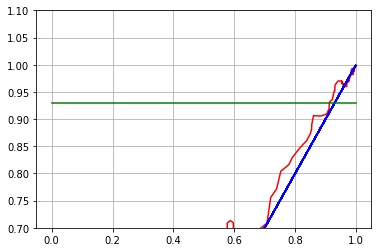

In [53]:
# Dynamic whole ship cable quantities
# Predictors:
# Current quantity, drawings
# Algorithms:
# average drawing cables


def moving_average(a, n=3) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

# Get the data
cursor.execute("SELECT r.project_id, gross_tonnage, prototype, ship_squares, sum(amount) FROM routed as r"
    " LEFT JOIN projects as p ON p.project_id=r.project_id"
    " LEFT JOIN (SELECT project_id, sum(squares) as ship_squares FROM areas GROUP BY project_id) as a ON r.project_id=a.project_id"
    " GROUP BY r.project_id, gross_tonnage, prototype, ship_squares")
data = np.array(cursor.fetchall()).astype('float32')
ships = data[:, 0]
gt = data[:, 1]
y = data[:, -1]

# init lpo split
p = 1 #ships
lpo = LeavePOut(p)

# update temporary cable counts
cursor.execute("UPDATE progress SET cables=0")
cursor.execute(
    "UPDATE progress SET progress.cables=t1.cables FROM"
    " (SELECT project_id, pw, sum(amount) as cables FROM ship_readiness GROUP BY project_id, pw) t1"
    " WHERE t1.project_id=progress.project_id AND t1.pw=progress.wk"
)
cursor.commit()

model = linear_model.LinearRegression()


accs = []
dum_accs = []
completeness = []
for train_i, test_i in lpo.split(y):
    # train regression model
    model.fit(gt[train_i].reshape(-1, 1), y[train_i])
    # collect time series train data
    start = -100
    step = 5
    x = []
    # train and evaluate
    for i in test_i:
        ship = ships[i]
        for wk in range(start, 1, step):
            # train the model
            cursor.execute('''
                DECLARE @pred_avg int; 
                SET @pred_avg = (SELECT avg(per_drw) FROM ( 
                SELECT drawing, sum(amount) as per_drw FROM drawing_types WHERE pw<={} AND project_id={} GROUP BY drawing) t1); 
                IF (@pred_avg IS Null) 
                SET @pred_avg = 0; 
                
                SELECT sum(preds) as pred FROM (
                SELECT drawing, case when avg_sys is null then @pred_avg ELSE avg_sys END as preds FROM ( 
                SELECT t4.drawing, avg_sys FROM 
                (SELECT system, drawing FROM ( 
                SELECT drawing, system, min(pw) as earliest FROM drawing_types WHERE project_id={} GROUP BY drawing, system) t3 
                WHERE earliest > {} 
                ) t4 
                LEFT JOIN  
                (SELECT system, avg(per_drw) as avg_sys, count(*) as drw_cnt FROM ( 
                SELECT drawing, system, sum(amount) as per_drw FROM drawing_types WHERE pw<={} AND project_id={} GROUP BY drawing, system) t1
                GROUP BY system) t2 
                ON t4.system=t2.system WHERE drw_cnt > 1
                ) t5
                ) t6
            '''.format(wk, ship, ship, wk, wk, ship))
            pred_end = cursor.fetchone()[0]
            if pred_end is None:
                pred_end = 0
            linear_pred = model.predict(gt[[i]].reshape(1, 1))[0]
            cursor.execute(
                "SELECT wk, cables FROM progress WHERE"
                " wk <= {} AND project_id={} ORDER BY wk"
                .format(wk, ship)
            )
            data = np.array(cursor.fetchall())
            sequence = data[:, -1]
            pred = sequence.sum() + pred_end
            _mape = abs(y[i]-pred)/y[i]
 
            accs.append(1-_mape)

            dum_mape = abs(sequence.sum()-y[i])/y[i]
            dum_accs.append(1-dum_mape)

            completeness.append(sequence.sum()/y[i])

org_completeness = completeness
accs = np.array(accs)
completeness = np.array(completeness)
p = np.argsort(completeness)
completeness = completeness[p]
accs = accs[p]

n = 6
accs = moving_average(accs, n)
plt.plot(completeness[n-1:], accs, 'r')
plt.plot(org_completeness, dum_accs, 'b')
plt.plot([0, 1], [0.93, 0.93], 'g')

plt.ylim(0.7, 1.1)
plt.grid(which='major')

plt.show()
